=== LDA (transform) + Logistic Regression ===
Test accuracy: 1.0
Confusion matrix:
 [[12  0  0]
 [ 0 14  0]
 [ 0  0 10]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36


=== LDA used directly as classifier ===
Test accuracy: 1.0
Confusion matrix:
 [[12  0  0]
 [ 0 14  0]
 [ 0  0 10]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



C:\Users\Nishok\miniconda3\envs\ml_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
C:\Users\Nishok\miniconda3\envs\ml_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(



=== GridSearch for Logistic ===
 Best CV params: {'clf__C': 10, 'lda__n_components': 2}
 Test accuracy: 1.0

=== GridSearch for SVM_linear ===
 Best CV params: {'clf__C': 0.1, 'lda__n_components': 2}
 Test accuracy: 1.0


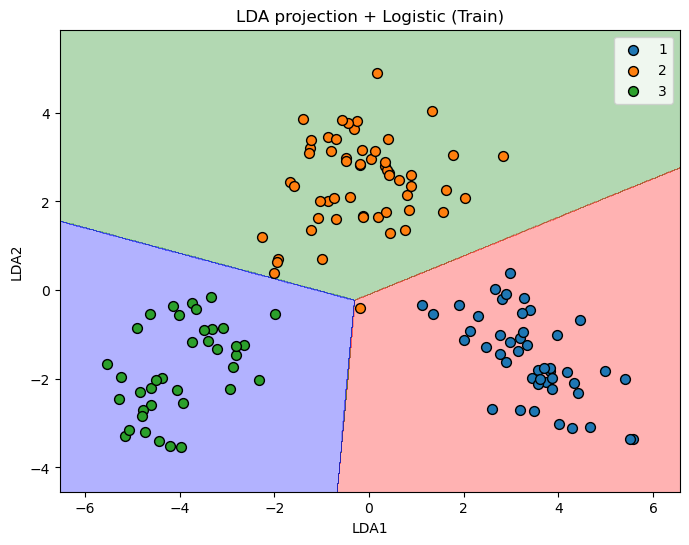

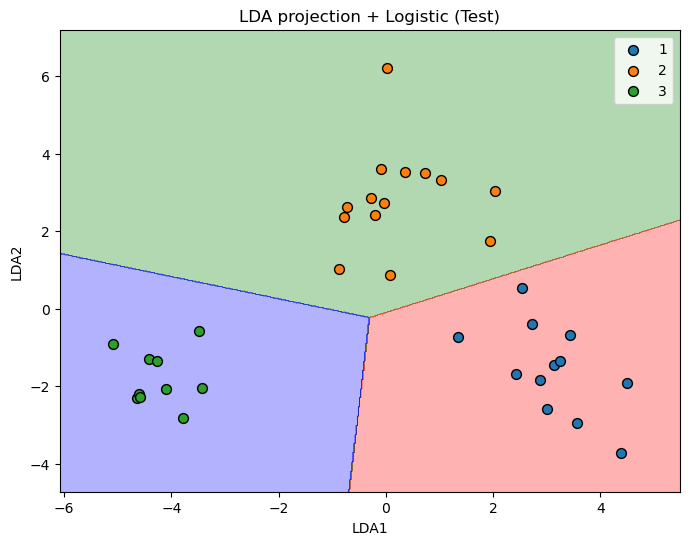

In [1]:
# lda_wine_example.py
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# --- load data ---
df = pd.read_csv("Wine.csv")
X = df.iloc[:, 0:13].values
y = df.iloc[:, 13].values

# train/test split (stratify to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=0, stratify=y
)

# --- Option A: LDA as transformer (reduce then classify) ---
# Note: n_components <= (n_classes - 1). Wine has 3 classes -> max 2 components.
pipe_lda_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("lda", LinearDiscriminantAnalysis(n_components=2)),
    ("clf", LogisticRegression(max_iter=2000, random_state=0))
])

pipe_lda_lr.fit(X_train, y_train)
y_pred = pipe_lda_lr.predict(X_test)

print("=== LDA (transform) + Logistic Regression ===")
print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# --- Option B: LDA as classifier directly (LDA has .predict) ---
lda_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("lda_clf", LinearDiscriminantAnalysis())   # n_components optional here; default uses full
])
lda_clf.fit(X_train, y_train)
y_pred2 = lda_clf.predict(X_test)

print("\n=== LDA used directly as classifier ===")
print("Test accuracy:", accuracy_score(y_test, y_pred2))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

# --- Optional: GridSearch across a few classifiers (tune small hyperparams) ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
models = {
    "Logistic": (LogisticRegression(max_iter=2000, solver="liblinear", random_state=0),
                 {"lda__n_components": [1, 2], "clf__C": [0.01, 0.1, 1, 10]}),
    "SVM_linear": (SVC(kernel="linear", random_state=0),
                 {"lda__n_components": [1, 2], "clf__C": [0.1, 1, 10]}),
}

results = []
for name, (estimator, param_grid) in models.items():
    # Pipeline: scale -> LDA (transform) -> classifier
    pipe = Pipeline([("scaler", StandardScaler()), ("lda", LinearDiscriminantAnalysis()), ("clf", estimator)])
    gs = GridSearchCV(pipe, param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
    gs.fit(X_train, y_train)
    best = gs.best_estimator_
    y_pred_gs = best.predict(X_test)
    acc = accuracy_score(y_test, y_pred_gs)
    print(f"\n=== GridSearch for {name} ===")
    print(" Best CV params:", gs.best_params_)
    print(" Test accuracy:", acc)
    results.append((name, gs.best_score_, acc, gs.best_params_))

# --- Visualization helper: plot 2D LDA projection and decision regions ---
def plot_lda_decision(pipe_with_lda_and_clf, X, y, title="LDA decision plot", step=0.02):
    # expects pipeline with scaler -> lda -> clf where lda n_components=2
    scaler = pipe_with_lda_and_clf.named_steps["scaler"]
    lda = pipe_with_lda_and_clf.named_steps["lda"]
    clf = pipe_with_lda_and_clf.named_steps["clf"]

    X_trans = lda.transform(scaler.transform(X))  # shape (n_samples, 2)
    x_min, x_max = X_trans[:, 0].min()-1, X_trans[:, 0].max()+1
    y_min, y_max = X_trans[:, 1].min()-1, X_trans[:, 1].max()+1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = clf.predict(grid).reshape(xx.shape)

    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(["red","green","blue"]))
    for i, cls in enumerate(np.unique(y)):
        plt.scatter(X_trans[y==cls, 0], X_trans[y==cls, 1],
                    label=str(cls), edgecolor="k", s=50)
    plt.title(title)
    plt.xlabel("LDA1")
    plt.ylabel("LDA2")
    plt.legend()
    plt.show()

# Refit a 2-component pipeline for visualization
viz_pipe = Pipeline([("scaler", StandardScaler()), ("lda", LinearDiscriminantAnalysis(n_components=2)),
                     ("clf", LogisticRegression(max_iter=2000, solver="liblinear"))])
viz_pipe.fit(X_train, y_train)
plot_lda_decision(viz_pipe, X_train, y_train, title="LDA projection + Logistic (Train)")
plot_lda_decision(viz_pipe, X_test, y_test, title="LDA projection + Logistic (Test)")
